# Data Prep & Modeling
## Filtering

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
# filter walks and strikeout events
marte_raw.dropna(axis='rows', subset=['woba_denom', 'xwOBA'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits, walks, strikeouts: {marte_raw.shape}")

# filter missing observation data
marte_raw.dropna(axis='rows', subset=['release_spin_rate'], how='any', inplace=True)
print(f"data-set shape after to filtering missing spin observations: {marte_raw.shape}")

data-set shape prior to filtering: (867, 29)
data-set shape after to filtering sac hits, walks, strikeouts: (681, 29)
data-set shape after to filtering missing spin observations: (675, 29)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

## Filtering ext., Computed Features, NaN Conversions

In [2]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['woba_value','game_year', 'pitcher', 'game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# if you do not filter walks and strikeouts from the raw data, this will allow more granular filtering
################################################################
# # if the xwOBA stat is NaN & a strikeout, then need to use the woba_value
# marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if (math.isnan(x.xwOBA) and x.woba_value == 0.0) else x.xwOBA, axis=1)
#
# # filter out walks, dropped 54 walks
# marte_vs.dropna(axis='rows', subset=['xwOBA'], how='any', inplace=True)
# print(f"data-set shape after to filtering walks: {marte_vs.shape}")
##########################################################

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())

new data-set shape after to filtering for proper metrics: (675, 8)
number of NaN xwOBA PAs prior to conversion: 0
   xwOBA p_throws pitch_type  release_speed  release_spin_rate  zone  pfx_x  \
0  0.709        R         SI           92.9             2303.0     5  -1.15   
1  0.262        R         SI           92.6             2316.0     9  -1.05   
2  0.231        R         SI           93.0             2245.0     8  -1.13   
3  0.117        L         SI           93.3             2189.0     8   1.19   
4  0.438        R         SI           94.1             2126.0     4  -1.34   

   pfx_z     pfx_v  
0   0.68  1.336001  
1   0.80  1.320038  
2   0.79  1.378768  
3   0.28  1.222497  
4   0.45  1.413542  


## Transformations
### Dummies
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [3]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()

,xwOBA,release_speed,release_spin_rate,pfx_x,pfx_z,pfx_v,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,92.9,2303.0,-1.15,0.68,1.336001,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.262,92.6,2316.0,-1.05,0.80,1.320038,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.231,93.0,2245.0,-1.13,0.79,1.378768,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.117,93.3,2189.0,1.19,0.28,1.222497,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.438,94.1,2126.0,-1.34,0.45,1.413542,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Feature and output transformations

In [4]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs_trx.drop(columns=['xwOBA'])  # remove response var and extra features, spin_axis should be converted to categorical if desired to use in analysis, removed earlier on ingest

y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

# transform numerical data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_feats = ['release_speed', 'release_spin_rate', 'pfx_v', 'pfx_x', 'pfx_z']
# print(X[num_feats].describe())
# used for positive values
pt = PowerTransformer()
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
# mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
# y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# # normalize on the test output, converted to a pandas.Series with the original indicies
# y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)

print('Train trx set shape\n', X_train_trx.shape, y_train.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test.shape)
print('---')

Train set shape
 (438, 28) (438,)
Test set shape
 (237, 28) (237,)
---
Train trx set shape
 (438, 5) (438,)
Test trx set shape
 (237, 5) (237,)
---


## Modeling
### Naive Model
*Note: did not transform the output for the naive model.

In [5]:
# Marte's xwOBA for last 4 seasons ('19-'22) == .348 || without walks xwOBA == .305
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.365, index=range(0, y_train.size))
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y_train, y_pred=y_same_xwOBA, squared=False)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y_true=y_train, y_pred=y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

0.36489185185185186
naive mse: 0.36604190443047196
naive r2 score: -0.0003866610950109539


### NN
#### Model 1

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow_addons.metrics import RSquare



# normalizer = preprocessing.Normalization()
# normalizer.adapt(np.array(train_features))
X_1 = X_train.release_spin_rate
X_1_test = X_test.release_spin_rate
number_of_inputs = 1  # number of features
model = keras.Sequential([layers.Dense(3, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(3, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

print("Fit model on training data")
history = model.fit(
    X_1,
    y_train,
    batch_size=42,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_1_test, y_test),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_1_test, y_test, batch_size=30)
print("test loss, test acc:", results)

print("Generate predictions for test data")
predictions = model.predict(X_1_test)
print("predictions shape:", predictions.shape)

X1_rmse = mean_squared_error(y_true=y_test, y_pred=predictions, squared=False)
print(f"rmse: {X1_rmse}")

X1_r2 = r2_score(y_true=y_test, y_pred=predictions)
print(f"r2 score: {X1_r2}")

2022-12-14 18:06:20.911143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fit model on training data
Epoch 1/100


2022-12-14 18:06:25.357686: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11/11 [==============================] - 1s 24ms/step - loss: 0.2582 - root_mean_squared_error: 0.5081 - mean_absolute_error: 0.3529 - r_square: -0.9278 - val_loss: 0.2619 - val_root_mean_squared_error: 0.5117 - val_mean_absolute_error: 0.3656 - val_r_square: -1.0231
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977 - mean_absolute_error: 0.3406 - r_square: -0.8495 - val_loss: 0.2504 - val_root_mean_squared_error: 0.5004 - val_mean_absolute_error: 0.3533 - val_r_square: -0.9343
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866 - mean_absolute_error: 0.3283 - r_square: -0.7682 - val_loss: 0.2384 - val_root_mean_squared_error: 0.4883 - val_mean_absolute_error: 0.3405 - val_r_square: -0.8420
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2249 - root_mean_squared_error: 0.4743 - mean_absolute_error: 0.3154 - r_square: -0.6794 - val_loss

<AxesSubplot:xlabel='xwOBA'>

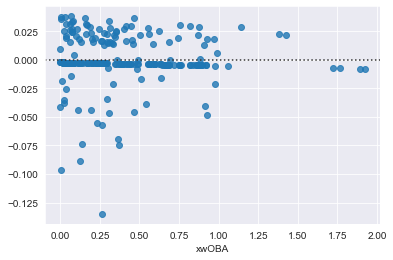

In [7]:
import seaborn as sns
sns.residplot(x=y_test, y=predictions)

#### NN2 -- Higher Fidelity Model

In [8]:

X_feats2 = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'pfx_v', 'pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
X_full = X_train[X_feats2]
X_full_test = X_test[X_feats2]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(3, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(3, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train,
    batch_size=42,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test, batch_size=26)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
X2_predictions = model.predict(X_full_test)
print("predictions shape:", predictions.shape)

X2_rmse = mean_squared_error(y_true=y_test, y_pred=X2_predictions, squared=False)
print(f"rmse: {X2_rmse}")

X2_r2 = r2_score(y_true=y_test, y_pred=X2_predictions)
print(f"r2 score: {X2_r2}")

Fit model on training data
Epoch 1/100
11/11 [==============================] - 1s 30ms/step - loss: 0.2939 - root_mean_squared_error: 0.5421 - mean_absolute_error: 0.3947 - r_square: -1.1944 - val_loss: 0.3441 - val_root_mean_squared_error: 0.5866 - val_mean_absolute_error: 0.4383 - val_r_square: -1.6585
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2608 - root_mean_squared_error: 0.5107 - mean_absolute_error: 0.3711 - r_square: -0.9471 - val_loss: 0.3024 - val_root_mean_squared_error: 0.5499 - val_mean_absolute_error: 0.4115 - val_r_square: -1.3362
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2409 - root_mean_squared_error: 0.4909 - mean_absolute_error: 0.3547 - r_square: -0.7990 - val_loss: 0.2802 - val_root_mean_squared_error: 0.5294 - val_mean_absolute_error: 0.3947 - val_r_square: -1.1650
Epoch 4/100
11/11 [==============================] - 0s 3ms/step - loss: 0.2301 - root_mean_squared_error: 0.4797 - mean_absolute_error

<AxesSubplot:xlabel='xwOBA'>

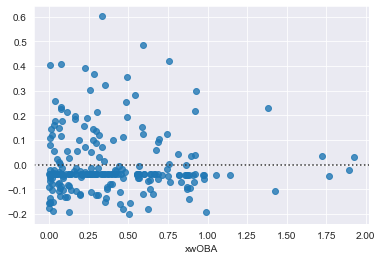

In [9]:
sns.residplot(x=y_test, y=X2_predictions)

Fit model on training data
Epoch 1/400
11/11 [==============================] - 1s 20ms/step - loss: 0.4794 - root_mean_squared_error: 0.4890 - mean_absolute_error: 0.3316 - r_square: -0.7853 - val_loss: 0.4669 - val_root_mean_squared_error: 0.4800 - val_mean_absolute_error: 0.3334 - val_r_square: -0.7799
Epoch 2/400
11/11 [==============================] - 0s 3ms/step - loss: 0.4553 - root_mean_squared_error: 0.4707 - mean_absolute_error: 0.3146 - r_square: -0.6539 - val_loss: 0.4456 - val_root_mean_squared_error: 0.4641 - val_mean_absolute_error: 0.3188 - val_r_square: -0.6642
Epoch 3/400
11/11 [==============================] - 0s 3ms/step - loss: 0.4352 - root_mean_squared_error: 0.4557 - mean_absolute_error: 0.3016 - r_square: -0.5506 - val_loss: 0.4268 - val_root_mean_squared_error: 0.4504 - val_mean_absolute_error: 0.3077 - val_r_square: -0.5673
Epoch 4/400
11/11 [==============================] - 0s 3ms/step - loss: 0.4181 - root_mean_squared_error: 0.4434 - mean_absolute_error

<AxesSubplot:xlabel='xwOBA'>

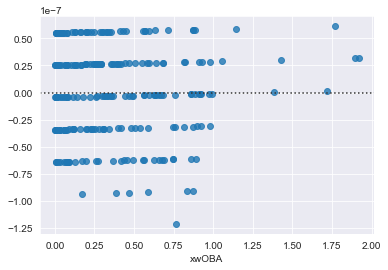

In [10]:
from tensorflow.keras import regularizers

X_feats3 = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z', 'pfx_v', 'pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
X_full = X_train[X_feats3]
X_full_test = X_test[X_feats3]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(3, activation='relu', kernel_regularizer=regularizers.l1_l2(), input_dim=number_of_inputs),
                          layers.Dense(3, activation='relu', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train,
    batch_size=42,
    epochs=400,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
X3_predictions = model.predict(X_full_test[X_feats3])
print("predictions shape:", predictions.shape)

X3_rmse = mean_squared_error(y_true=y_test, y_pred=X3_predictions, squared=False)
print(f"rmse: {X3_rmse}")

X3_r2 = r2_score(y_true=y_test, y_pred=X3_predictions)
print(f"r2 score: {X3_r2}")

sns.residplot(x=y_test, y=X3_predictions)

#### Hyper sweep

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_95451/3098701642.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)
2022-12-14 18:06:41.963036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 18:06:41.963567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with 

3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 3ms/step


3/3 [==============================] - 0s 8ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 5ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 623us/step


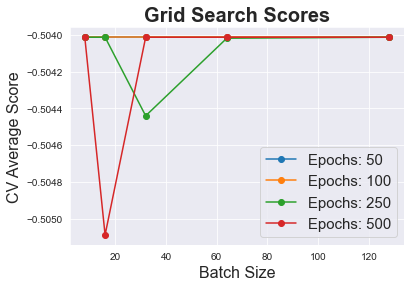

In [11]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_and_compile_model():
    # create model
    model = keras.Sequential([layers.Dense(3, activation='relu', input_dim=number_of_inputs),
                              layers.Dense(3, activation='relu'),
                              layers.Dense(1, activation='linear')]) # output layer for regression

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
batch_size = [8, 16, 32, 64, 128]
epochs = [50, 100, 250, 500]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)

grid_result = grid.fit(X_full, y_train)

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method
plot_grid_search(grid_result.cv_results_, batch_size, epochs, 'Batch Size', 'Epochs')

In [12]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.504013 using {'batch_size': 8, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 250}
train accuracy -0.504013 for: {'batch_size': 8, 'epochs': 500}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 250}
train accuracy -0.504013 for: {'batch_size': 16, 'epochs': 500}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 50}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 250}
train accuracy -0.504013 for: {'batch_size': 32, 'epochs': 500}
train accuracy -0.504441 for: {'batch_size': 64, 'epochs': 50}
train accuracy -0.504018 for: {'batch_size': 64, 'epochs': 100}
train accuracy -0.504013 for: {'batch_size': 64, 'epochs':

In [13]:
def create_and_compile_model(num_neurons, num_layers):
    # create model
    model = keras.Sequential()
    model.add(Dense(num_neurons, input_dim=number_of_inputs, activation='relu'))

    if num_layers > 0:
        while num_layers > 0:
            model.add(Dense(num_neurons, activation='relu'))
            num_layers=num_layers-1

    model.add(Dense(1, activation='linear')) # output layer for regression

    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

    print(model.summary())
    print('--')

    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
num_neurons_grid = [2, 3, 4, 5, 8, 10, 16]
num_layers_grid = [1, 2, 3, 4]

param_grid = dict(num_neurons=num_neurons_grid, num_layers=num_layers_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)

grid_result = grid.fit(X_full, y_train)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 2)                 28        
                                                                 
 dense_49 (Dense)            (None, 2)                 6         
                                                                 
 dense_50 (Dense)            (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 2)                 28        
                                                                 
 dense_40 (Dense)            (None

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_95451/3178102371.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 2)                 28        
                                                                 
 dense_46 (Dense)            (None, 2)                 6         
                                                                 
 dense_47 (Dense)            (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 3)                 42        
                                                                 
 dense_22 (Dense)            (None,

Best: -0.505448 using {'num_layers': 1, 'num_neurons': 4}
train accuracy -0.505874 for: {'num_layers': 1, 'num_neurons': 2}
train accuracy -0.506097 for: {'num_layers': 1, 'num_neurons': 3}
train accuracy -0.505448 for: {'num_layers': 1, 'num_neurons': 4}
train accuracy -0.505890 for: {'num_layers': 1, 'num_neurons': 5}
train accuracy -0.506020 for: {'num_layers': 1, 'num_neurons': 8}
train accuracy -0.505806 for: {'num_layers': 1, 'num_neurons': 10}
train accuracy -0.505673 for: {'num_layers': 1, 'num_neurons': 16}
train accuracy -0.506133 for: {'num_layers': 2, 'num_neurons': 2}
train accuracy -0.505934 for: {'num_layers': 2, 'num_neurons': 3}
train accuracy -0.505984 for: {'num_layers': 2, 'num_neurons': 4}
train accuracy -0.506011 for: {'num_layers': 2, 'num_neurons': 5}
train accuracy -0.505667 for: {'num_layers': 2, 'num_neurons': 8}
train accuracy -0.505839 for: {'num_layers': 2, 'num_neurons': 10}
train accuracy -0.505850 for: {'num_layers': 2, 'num_neurons': 16}
train accuracy

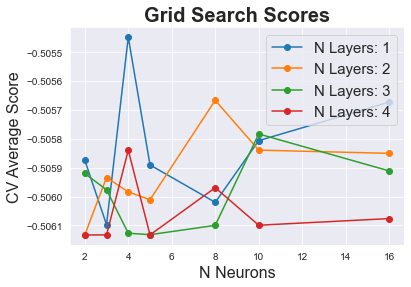

In [14]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

# Calling Method
plot_grid_search(grid_result.cv_results_, num_neurons_grid, num_layers_grid, 'N Neurons', 'N Layers')

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

#### Combining Sweep

Fit model on training data
Evaluate on test data
30/30 [==============================] - 0s 676us/step - loss: 0.1495 - root_mean_squared_error: 0.3601 - mean_absolute_error: 0.2757 - r_square: -0.0018
test loss, test acc: [0.14950770139694214, 0.3600836992263794, 0.2757437229156494, -0.0017532110214233398]
Generate predictions
8/8 [==============================] - 0s 688us/step
predictions shape: (237, 1)
rmse: 0.36008372454615206
r2 score: -0.0017527357558242418


<AxesSubplot:xlabel='xwOBA'>

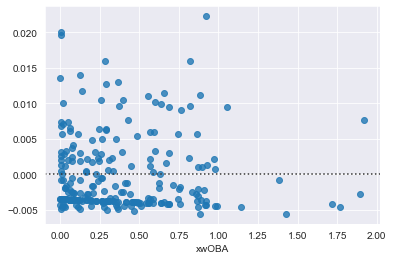

In [15]:
model = keras.Sequential([layers.Dense(10, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(10, activation='sigmoid', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train,
    batch_size=8,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test),
    callbacks=[callback],
    verbose=0
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test, batch_size=8)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
X4_predictions = model.predict(X_full_test)
print("predictions shape:", X4_predictions.shape)

X4_rmse = mean_squared_error(y_true=y_test, y_pred=X4_predictions, squared=False)
print(f"rmse: {X4_rmse}")

X4_r2 = r2_score(y_true=y_test, y_pred=X4_predictions)
print(f"r2 score: {X4_r2}")

sns.residplot(x=y_test, y=X4_predictions)

TW NN

# of inputs = 28


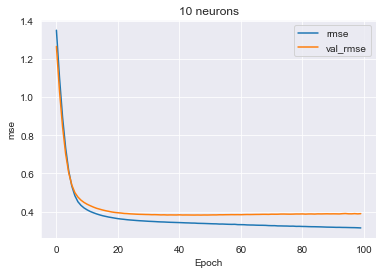

14/14 [==============================] - 0s 718us/step
MAE Train = 0.23456965895398565
RMSE Train = 0.3134021822474282
R2  = 0.26665166171970534

8/8 [==============================] - 0s 675us/step
MAE Test = 0.30210055072071174
RMSE Test = 0.38936912132063467
R2  = -0.17132271947750422


In [16]:
# Define the loss plot
def plot_loss(history, num_neurons):
    plt.plot(history.history['root_mean_squared_error'], label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
    # plt.ylim([0, y_lim])
    plt.xlabel('Epoch')
    plt.ylabel('mse')
    plt.legend()
    plt.title(f"{num_neurons} neurons")

    plt.grid(True)
    plt.show()

from   tensorflow.keras import layers, regularizers
from   tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
from   tensorflow.keras.optimizers import Adam

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs= X_train.shape[1]
print(f"# of inputs = {number_of_inputs}")

num_neurons = 10

# create model
model = keras.Sequential([normalizer,
                          layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(num_neurons, activation='sigmoid'),
                          layers.Dense(1, activation='linear') ])  
  
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

history = model.fit(X_train, 
                    y_train,
                    batch_size=20,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    verbose=0)  # Calculate validation results on 35% of the training data
                  
# Isolate and plot training curves 
hist = pd.DataFrame(history.history)
plot_loss(history, num_neurons)

# calculate metrics ---------------
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train
y_pred = model.predict(X_train)
print(f"MAE Train = {mean_absolute_error(y_train, y_pred)}")
print(f"RMSE Train = {mean_squared_error(y_train, y_pred, squared=False)}")
print(f"R2  = {                 r2_score(y_train, y_pred)}")
print(f"")

# holdout
y_pred = model.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE Test = {mean_squared_error(y_test, y_pred, squared=False)}")
print(f"R2  = {                r2_score(y_test, y_pred)}")

TW NN neurons sweep

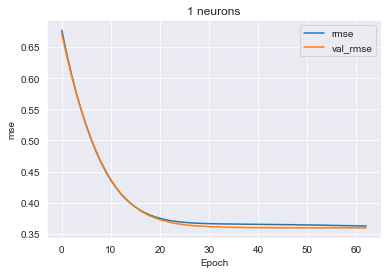

14/14 [==============================] - 0s 684us/step
MAE Train =     0.28013001829031947
RMSE Train =    0.3624305705361683
R2 =            0.019255400593081284

8/8 [==============================] - 0s 852us/step
MAE Test =      0.2752502890810181
RMSE Test =     0.35945072041492676
R2 =            0.001766202821183338


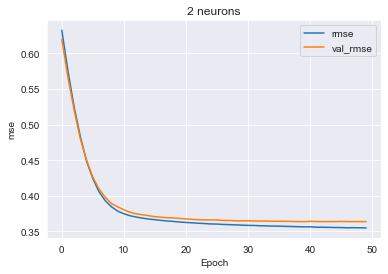

14/14 [==============================] - 0s 707us/step
MAE Train =     0.2730867489323224
RMSE Train =    0.35437732816503265
R2 =            0.06235565483782668

8/8 [==============================] - 0s 632us/step
MAE Test =      0.28058771490648327
RMSE Test =     0.36383466047356117
R2 =            -0.022731640208315973


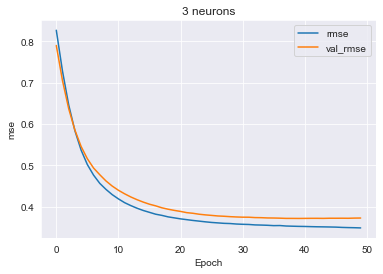

14/14 [==============================] - 0s 649us/step
MAE Train =     0.26754194153579947
RMSE Train =    0.34793259613161953
R2 =            0.09614968207716867

8/8 [==============================] - 0s 806us/step
MAE Test =      0.286955927455224
RMSE Test =     0.3725409860860002
R2 =            -0.07226386960015319


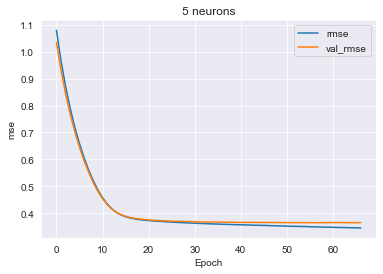

14/14 [==============================] - 0s 795us/step
MAE Train =     0.2638945731390013
RMSE Train =    0.3450314183143448
R2 =            0.11116004906272214

8/8 [==============================] - 0s 688us/step
MAE Test =      0.28180360364008555
RMSE Test =     0.36512304047861
R2 =            -0.029987683371281326


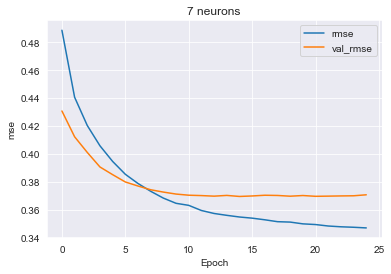

14/14 [==============================] - 0s 666us/step
MAE Train =     0.2630305512747196
RMSE Train =    0.345256709923644
R2 =            0.10999891677551876

8/8 [==============================] - 0s 716us/step
MAE Test =      0.28536923522058916
RMSE Test =     0.37061429821241076
R2 =            -0.061201593666378784


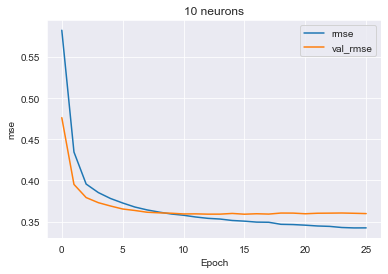

14/14 [==============================] - 0s 681us/step
MAE Train =     0.2590052121265294
RMSE Train =    0.33995438047253707
R2 =            0.13712564222060597

8/8 [==============================] - 0s 663us/step
MAE Test =      0.2780352802850023
RMSE Test =     0.3596505735025221
R2 =            0.0006558666566731652


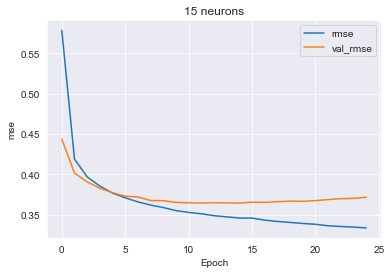

14/14 [==============================] - 0s 617us/step
MAE Train =     0.24941729669592697
RMSE Train =    0.3309743533499512
R2 =            0.18210987522771138

8/8 [==============================] - 0s 826us/step
MAE Test =      0.28690441088988305
RMSE Test =     0.371606559827438
R2 =            -0.06689160195526123


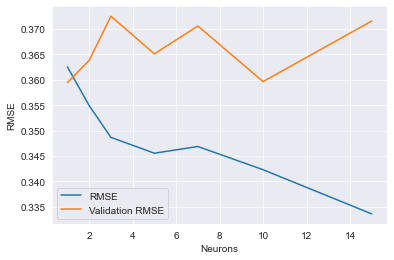

In [17]:
# Define the loss plot
def plot_loss(history):
    plt.plot(history.history['root_mean_squared_error'], label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
    # plt.ylim([0, y_lim])
    plt.xlabel('Epoch')
    plt.ylabel('mse')
    plt.legend()
    plt.title(f"{num_neurons} neurons")

    plt.grid(True)
    plt.show()


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs = X_train.shape[1]

# sweep neurons
mse_list = []
val_mse_list = []

neurons_to_try = [1, 2, 3, 5, 7, 10, 15]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

for num_neurons in neurons_to_try:

    #---- pasted in model
    model = keras.Sequential([normalizer,
                            layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                            layers.Dense(num_neurons, activation='sigmoid'),
                            layers.Dense(1, activation='linear') ])

    model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

    history = model.fit(X_train, y_train,
                        epochs=200,
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        callbacks=[callback],
                        verbose=0)  # Calculate validation results on 35% of the training data

    # Isolate the metric for each epoch.
    hist = pd.DataFrame(history.history)

    #---- end model paste

    # record metrics

    current_mse = hist['root_mean_squared_error']
    current_mse = current_mse[len(current_mse)-1]  # last element is the final value
    mse_list.append(current_mse)

    current_val_mse = hist['val_root_mean_squared_error']
    current_val_mse = current_val_mse[len(current_val_mse)-1] #  last element is the final value
    val_mse_list.append(current_val_mse)

    plot_loss(history)

    # calculate metrics ---------------
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score

    # train
    y_pred_train = model.predict(X_train)
    print(f"MAE Train =     {mean_absolute_error(y_train, y_pred_train)}")
    print(f"RMSE Train =    {mean_squared_error(y_train, y_pred_train, squared=False)}")
    print(f"R2 =            {r2_score(y_train, y_pred_train)}")
    print(f"")

    # holdout
    y_pred_test = model.predict(X_test)
    print(f"MAE Test =      {mean_absolute_error(y_test, y_pred_test)}")
    print(f"RMSE Test =     {mean_squared_error(y_test, y_pred_test, squared=False)}")
    print(f"R2 =            {r2_score(y_test, y_pred_test)}")

#plot results of sweep
plt.plot(neurons_to_try, mse_list, label='RMSE')
plt.plot(neurons_to_try, val_mse_list, label='Validation RMSE')

# plt.ylim([1,y_lim])
plt.xlabel('Neurons')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

#### Final model on Fastball only


In [18]:
# try groupby pitch_type
# convert pitch dummies to single column
org_pit_col_train = pd.from_dummies(X[['pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF',
                                       'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']],
                                    sep='pitch_type_')
# drop dummy pitch_types from transformed train set
X_grp_pit = X.drop(
    columns=['pitch_type_CH', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC',
             'pitch_type_SI', 'pitch_type_SL'], axis=1)
# # add back zipped column, need to use .values attribute or will have index issues
X_grp_pit['pitch_type'] = org_pit_col_train.values
# # groupby pitch_type
X_ff = X_grp_pit.groupby(['pitch_type']).get_group('FF')
X_ff = X_ff.drop(columns=['pitch_type'])
y = marte_vs.groupby(['pitch_type']).get_group('FF').xwOBA
X_train, X_test, y_train, y_test = train_test_split(X_ff, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

num_feats = ['release_speed', 'release_spin_rate', 'pfx_v', 'pfx_x', 'pfx_z']
# used for positive values
pt = PowerTransformer()
nct = ColumnTransformer(
    transformers=[
        ('pt_pre', pt, num_feats)
    ])

# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
# mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
# y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# # normalize on the test output, converted to a pandas.Series with the original indicies
# y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)


print('Train trx set shape\n', X_train_trx.shape, y_train.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test.shape)

Train set shape
 (177, 20) (177,)
Test set shape
 (96, 20) (96,)
---
Train trx set shape
 (177, 5) (177,)
Test trx set shape
 (96, 5) (96,)


In [19]:
#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

model = keras.Sequential([normalizer,
                          layers.Dense(10, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(10, activation='sigmoid', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=8,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=1
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=8)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
X5_predictions = model.predict(X_test)
print("predictions shape:", X5_predictions.shape)

X5_rmse = mean_squared_error(y_true=y_test, y_pred=X5_predictions, squared=False)
print(f"rmse: {X5_rmse}")

X5_r2 = r2_score(y_true=y_test, y_pred=X5_predictions)
print(f"r2 score: {X5_r2}")

Fit model on training data
Epoch 1/100
23/23 [==============================] - 1s 10ms/step - loss: 1.0768 - root_mean_squared_error: 0.4180 - mean_absolute_error: 0.3540 - r_square: -0.5499 - val_loss: 0.9980 - val_root_mean_squared_error: 0.3639 - val_mean_absolute_error: 0.3045 - val_r_square: -0.1804
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.9661 - root_mean_squared_error: 0.3603 - mean_absolute_error: 0.2920 - r_square: -0.1516 - val_loss: 0.9351 - val_root_mean_squared_error: 0.3654 - val_mean_absolute_error: 0.2989 - val_r_square: -0.1905
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.8894 - root_mean_squared_error: 0.3416 - mean_absolute_error: 0.2686 - r_square: -0.0349 - val_loss: 0.8639 - val_root_mean_squared_error: 0.3532 - val_mean_absolute_error: 0.2809 - val_r_square: -0.1120
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.8246 - root_mean_squared_error: 0.3363 - mean_absolute_error

<AxesSubplot:xlabel='xwOBA'>

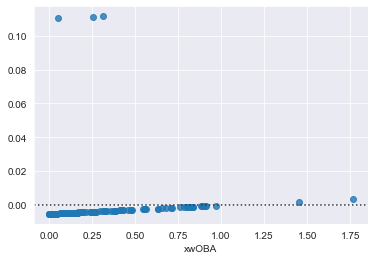

In [20]:
sns.residplot(x=y_test, y=X5_predictions)

In [21]:
from ann_visualizer.visualize import ann_viz

model = keras.Sequential([layers.Dense(10, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(10, activation='sigmoid', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear')])
ann_viz(model, title="Marte xwOBA Dataset NN")


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH